In [178]:
import os
import json

from pathlib import Path
from collections import defaultdict, Counter
from itertools import chain, starmap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Historic PSPS Data

In [179]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

### Load Weather Report data

In [180]:
wr = pd.read_csv("../data/sce.csv", parse_dates=["Time", "Date"])
wr.head()

,Status,Mnet_Id,Elevation,Name,Elev_Dem,Longitude,State,Restricted,Qc_Flagged,Latitude,Timezone,Id,Period_Of_Record.Start,Period_Of_Record.End,Time,RelHum,WindSpd,GustSpd,Date,Station
0,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:00:00,30.89,2.87,6.43,2021-01-12,SE001
1,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:10:00,30.83,3.27,8.26,2021-01-12,SE001
2,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:20:00,31.16,2.16,6.06,2021-01-12,SE001
3,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:30:00,32.43,1.29,4.38,2021-01-12,SE001
4,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:40:00,32.18,1.32,3.58,2021-01-12,SE001


In [181]:
wr_dt_columns = ["Date", "Time"]
wr_ts_columns = ["RelHum", "WindSpd", "GustSpd"]
wr_cat_columns = ["Station"]
wr_cat_real_columns = ["Latitude", "Longitude"]

Index(['Status', 'Mnet_Id', 'Elevation', 'Name', 'Elev_Dem', 'Longitude',
       'State', 'Restricted', 'Qc_Flagged', 'Latitude', 'Timezone', 'Id',
       'Period_Of_Record.Start', 'Period_Of_Record.End', 'Time', 'RelHum',
       'WindSpd', 'GustSpd', 'Date', 'Station'],
      dtype='object')

In [182]:
wind_gust_perc = wr[["WindSpd", "GustSpd"]].describe(percentiles=np.arange(0,1,.01))[-10:]
wind_gust_perc

,WindSpd,GustSpd
91%,14.91,26.96
92%,15.66,28.12
93%,16.51,29.37
94%,17.45,30.83
95%,18.61,32.44
96%,20.01,34.34
97%,21.81,36.74
98%,24.29,40.04
99%,28.12,45.23
max,70.64,98.90


In [183]:
hum_perc = wr["RelHum"].describe(percentiles=np.arange(0,1,.01))[4:15]
hum_perc

0%      0.88
1%      9.00
2%      9.97
3%     10.67
4%     11.22
5%     11.67
6%     12.05
7%     12.40
8%     12.73
9%     13.02
10%    13.31
Name: RelHum, dtype: float64

In [184]:
outliers = wr[(wr.WindSpd > wind_gust_perc.WindSpd["99%"]) & (wr.GustSpd > wind_gust_perc.GustSpd["99%"]) & (wr.RelHum < hum_perc["10%"])]

In [185]:
outliers.Id.unique()

array([ 71312,  72882,  88896,  89911,  89912,  92121, 108441, 125752,
       139780, 141651, 141652, 142942, 150331, 151178, 152233, 152320,
       152639, 152640, 152657, 152687, 156554, 156555])

### Visualizations by Station

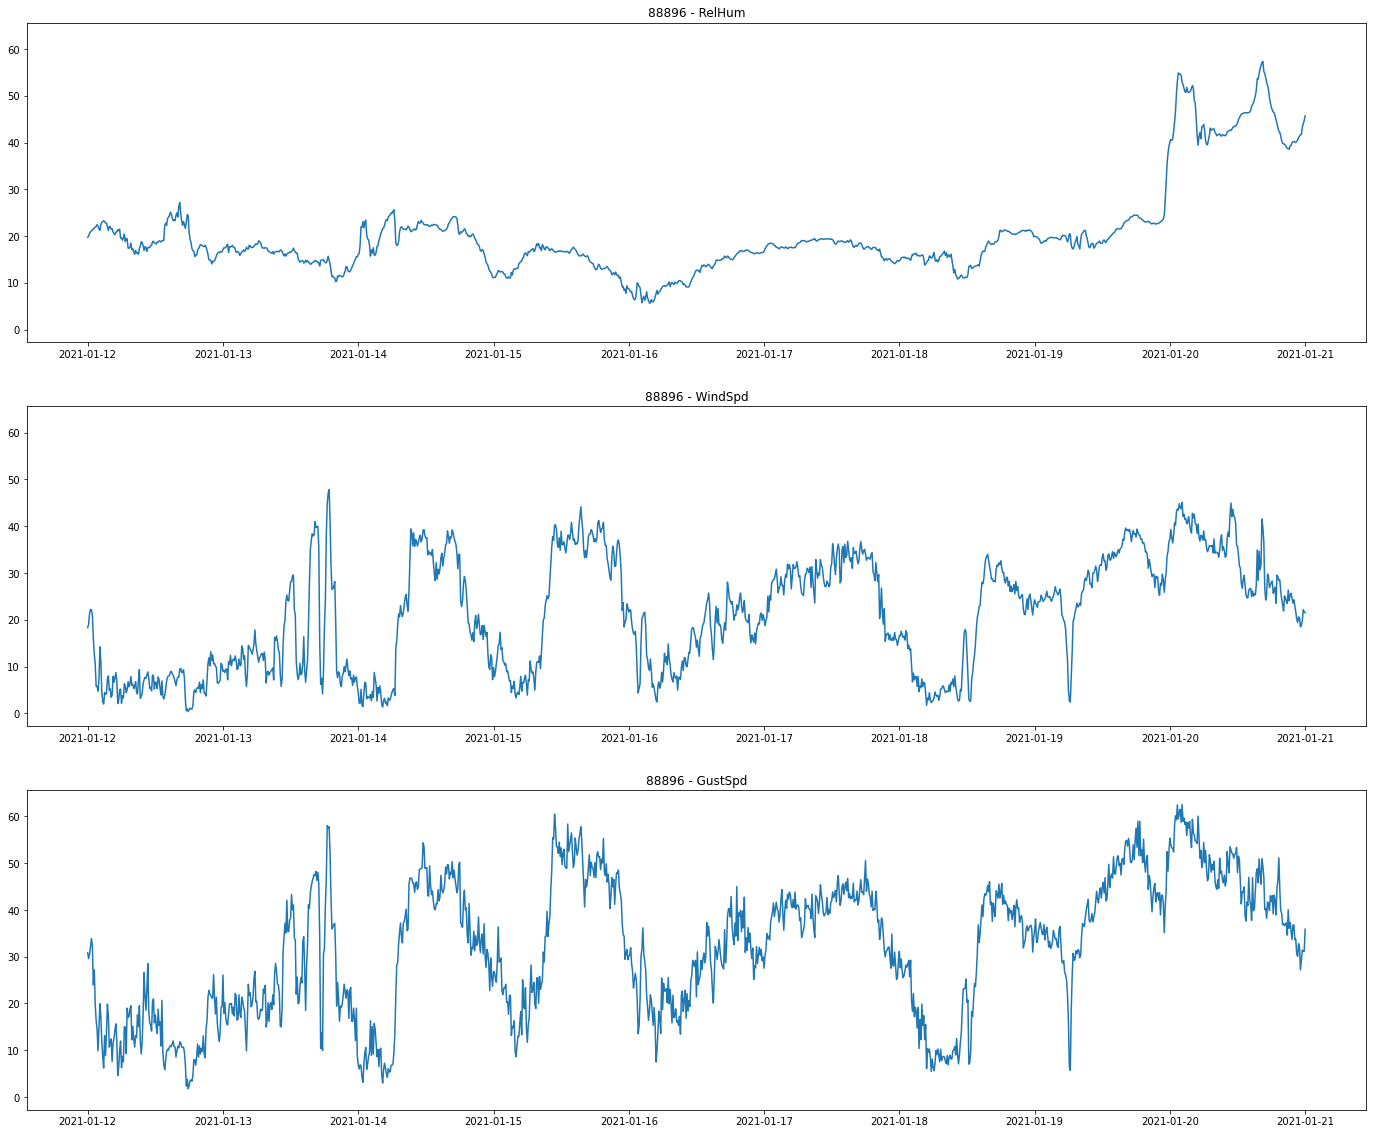

In [207]:
station_id = 88896
wrs = wr[(wr.Id==station_id)].copy().set_index("Time")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (c, v_ax) in zip(wr_ts_columns, ax): 
    v_ax.plot(wrs[c])
    v_ax.set_title("{} - {}".format(station_id, c))    

## GlutonTS

In [44]:
from gluonts.mx.trainer import Trainer
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

In [45]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepvar import DeepVAREstimator

In [199]:
wr_gts = wr.copy()
wr_gts.drop_duplicates(subset = ["Id"] + wr_ts_columns + wr_dt_columns, inplace=True)
wr_gts.set_index(["Time"], inplace=True)
wr_gts = wr_gts.loc[:"2021-01-20 00:00:00"]

In [200]:
# Filter out weather stations with < 8 days worth of 10-minute data
wr_gts_id_counts = wr_gts.groupby("Id").count().RelHum
wr_gts_ids = wr_gts_id_counts[wr_gts_id_counts >= 1152].index
wr_gts = wr_gts[wr_gts.Id.isin(wr_gts_ids)]

In [206]:
print("Number of Weather Stations:  {}".format(wr_gts.Id.unique().shape))
print("Number of records:  {}".format(wr_gts.index.shape))

Number of Weather Stations:  (261,)
Number of records:  (300901,)


In [203]:
train_outliers = wr_gts[(wr_gts.WindSpd > wind_gust_perc.WindSpd["99%"]) & (wr_gts.GustSpd > wind_gust_perc.GustSpd["99%"]) & (wr_gts.RelHum < hum_perc["10%"])]
train_outliers.Id.unique()

array([71312, 88896, 89911, 89912])

In [208]:
training_time_cutoff = "2021-01-19 00:00:00"

In [213]:
single_datasets = []
for (station_id, df) in wr_gts.groupby("Id"):
    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        single_datasets.append({
            "item_id": "Training:  {} - {}".format(station_id, c),
            "start": ts.index[0],
            "target": ts.loc[:training_time_cutoff],
            "feat_static_cat": [station_id],
            "feat_static_real": [df[wr_cat_real_columns[0]].unique()[0], df[wr_cat_real_columns[1]].unique()[0]] #lat, long
        })

In [214]:
single_datasets[0]

{'item_id': 'Training:  70844 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00'),
 'target': Time
 2021-01-12 00:00:00    30.89
 2021-01-12 00:10:00    30.83
 2021-01-12 00:20:00    31.16
 2021-01-12 00:30:00    32.43
 2021-01-12 00:40:00    32.18
                        ...  
 2021-01-18 23:20:00    21.12
 2021-01-18 23:30:00    21.28
 2021-01-18 23:40:00    21.44
 2021-01-18 23:50:00    21.83
 2021-01-19 00:00:00    22.28
 Name: RelHum, Length: 1009, dtype: float64,
 'feat_static_cat': [70844],
 'feat_static_real': [33.76594, -116.73432]}

In [215]:
all_single_training_data = ListDataset(
    single_datasets,
    freq = "10min",
)

In [216]:
next(iter(all_single_training_data))

{'item_id': 'Training:  70844 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00', freq='10T'),
 'target': array([30.89, 30.83, 31.16, ..., 21.44, 21.83, 22.28], dtype=float32),
 'feat_static_cat': array([70844], dtype=int32),
 'feat_static_real': array([  33.76594, -116.73432], dtype=float32),
 'source': SourceContext(source='list_data', row=0)}

In [217]:
estimator = DeepAREstimator(
    freq="10min", 
    prediction_length=6*24, # 24-hour prediction
    trainer=Trainer(epochs=100, batch_size=32), 
    num_layers=20,
    use_feat_static_cat = True, cardinality = [wr.Id.unique().shape[0]], 
    use_feat_static_real = True,
)

### Train a new model...

In [ ]:
predictor = estimator.train(training_data=all_single_training_data)

 30%|███       | 15/50 [00:53<02:05,  3.60s/it, epoch=2/100, avg_epoch_loss=2.63]

In [ ]:
prefix = "../models/"
model_name = "model-sce-20L-100E-complete-data"
try:
    os.mkdir(prefix + model_name)
finally:
    predictor.serialize(Path(prefix + model_name))

In [93]:
predictor = Predictor.deserialize(Path("../models/model-sce-20L-100E"))
predictor.prediction_length

144

### Visualize Predictions

In [147]:
testing_time_cutoff = "2021-01-20 00:00:00"

In [148]:
outliers.Id.unique()

array([ 71312,  72882,  88896,  89911,  89912,  92121, 108441, 125752,
       139780, 141651, 141652, 142942, 150331, 151178, 152233, 152320,
       152639, 152640, 152657, 152687, 156554, 156555])

In [169]:
test_station_id = 92121
wr_test = wr_gts[(wr_gts.Id==test_station_id)]

single_test_datasets = []

for (c, ts) in wr_test[wr_ts_columns].transpose().iterrows():
    single_test_datasets.append({
        "item_id": "Test:  {} - {}".format(test_station_id, c),
        "start": ts.index[0],
        "target": ts.loc[:testing_time_cutoff],
        "feat_static_cat": [test_station_id],
        "feat_static_real": [wr_test[wr_cat_real_columns[0]].unique()[0], wr_test[wr_cat_real_columns[1]].unique()[0]]
    })

In [187]:
single_test_datasets[0]["target"].index.shape

(1005,)

In [171]:
single_test_data = ListDataset(
    single_test_datasets,
    freq = "10min",
)

In [172]:
next(iter(single_test_data))

{'item_id': 'Test:  92121 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00', freq='10T'),
 'target': array([17.82, 18.02, 18.3 , ..., 17.74, 17.89, 18.02], dtype=float32),
 'feat_static_cat': array([92121], dtype=int32),
 'feat_static_real': array([  34.33086, -118.87478], dtype=float32),
 'source': SourceContext(source='list_data', row=0)}

In [173]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation
)

In [174]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

In [175]:
stss[1].index

DatetimeIndex(['2021-01-12 00:00:00', '2021-01-12 00:10:00',
               '2021-01-12 00:20:00', '2021-01-12 00:30:00',
               '2021-01-12 00:40:00', '2021-01-12 00:50:00',
               '2021-01-12 01:00:00', '2021-01-12 01:10:00',
               '2021-01-12 01:20:00', '2021-01-12 01:30:00',
               ...
               '2021-01-18 21:50:00', '2021-01-18 22:00:00',
               '2021-01-18 22:10:00', '2021-01-18 22:20:00',
               '2021-01-18 22:30:00', '2021-01-18 22:40:00',
               '2021-01-18 22:50:00', '2021-01-18 23:00:00',
               '2021-01-18 23:10:00', '2021-01-18 23:20:00'],
              dtype='datetime64[ns]', length=1005, freq='10T')

In [176]:
sforecasts[1].quantile_ts(".99")

2021-01-17 23:30:00    17.778393
2021-01-17 23:40:00    19.419752
2021-01-17 23:50:00    20.836195
2021-01-18 00:00:00    20.508392
2021-01-18 00:10:00    19.929003
                         ...    
2021-01-18 22:40:00    20.555311
2021-01-18 22:50:00    21.553970
2021-01-18 23:00:00    21.280287
2021-01-18 23:10:00    20.037693
2021-01-18 23:20:00    21.384090
Freq: 10T, Length: 144, dtype: float32

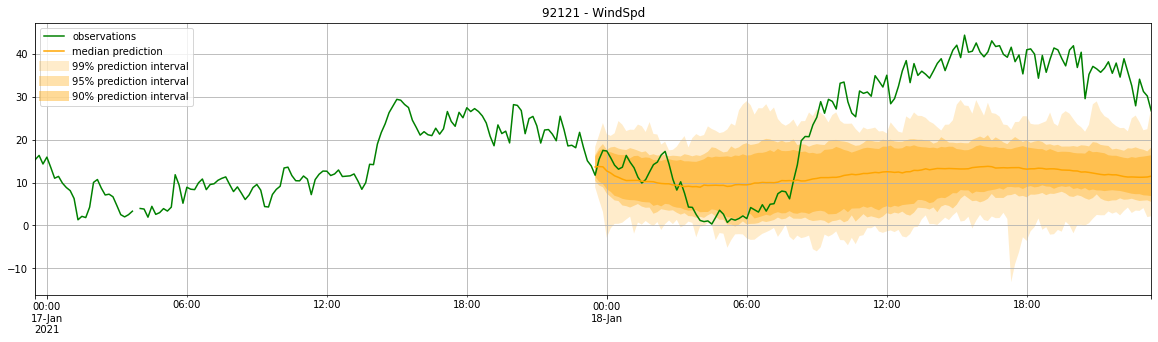

In [177]:
plot_length = 2*6*24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

i = 1
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

# plt.ylim(0,40)
plt.title("{} - {}".format(test_station_id, wr_ts_columns[i]))
plt.grid(which="both")
plt.legend(legend, loc="upper left")
# plt.savefig("../images/204_wind_3day.png")
plt.show()

### Gluon-ts Metrics

- Comp

In [94]:
all_single_test_datasets = []
excluded = 0
for (station_id, df) in wr_gts[wr_gts.Id.isin(outliers.Id.unique())].groupby("Id"):
    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        all_single_test_datasets.append({
            "item_id": "Training:  {} - {}".format(station_id, c),
            "start": ts.index[0],
            "target": ts.loc[:testing_time_cutoff],
            "feat_static_cat": [station_id],
            "feat_static_real": [df[wr_cat_real_columns[0]].unique()[0], df[wr_cat_real_columns[1]].unique()[0]] #lat, long
        })

In [95]:
all_single_test_data = ListDataset(
    all_single_test_datasets,
    freq = "10min",
)

In [96]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

In [97]:
evaluator = Evaluator(quantiles=[.75, .90, .99])
agg_metrics, item_metrics = evaluator(ts_all_it, forecast_all_it, num_series=len(all_single_test_data))

Running evaluation: 100%|██████████| 66/66 [14:00<00:00, 12.73s/it]  


In [98]:
# 20L 100E Outliers
agg_metrics

{'MSE': 370.9770070085622,
 'abs_error': 138364.10864257812,
 'abs_target_sum': 265206.58837890625,
 'abs_target_mean': 27.904733625726667,
 'seasonal_error': 10.050093771416078,
 'MASE': 1.7565738253162166,
 'MAPE': 0.841135515508427,
 'sMAPE': 0.558529733808755,
 'MSIS': 24.51679185433098,
 'QuantileLoss[0.75]': 139080.0369362831,
 'Coverage[0.75]': 0.5525042087542088,
 'QuantileLoss[0.9]': 114108.36221261026,
 'Coverage[0.9]': 0.6302609427609427,
 'QuantileLoss[0.99]': 56488.29189260483,
 'Coverage[0.99]': 0.7978745791245792,
 'RMSE': 19.26076340669191,
 'NRMSE': 0.6902328352252939,
 'ND': 0.5217219884631765,
 'wQuantileLoss[0.75]': 0.5244215001837607,
 'wQuantileLoss[0.9]': 0.43026216999398686,
 'wQuantileLoss[0.99]': 0.21299731744182318,
 'mean_absolute_QuantileLoss': 103225.5636804994,
 'mean_wQuantileLoss': 0.3892269958731902,
 'MAE_Coverage': 0.21978675645342313,
 'OWA': nan}

In [159]:
item_metrics.sort_values("Coverage[0.99]")

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.75],Coverage[0.75],QuantileLoss[0.9],Coverage[0.9],QuantileLoss[0.99],Coverage[0.99]
4,Training: 72882 - WindSpd,154.984972,1381.012451,2068.529785,14.364790,7.786096,1.231730,0.555959,0.844621,38.499720,1949.804553,0.076389,2178.792257,0.138889,1916.348590,0.333333
20,Training: 108441 - GustSpd,1185.719944,4021.926758,5598.760254,38.880280,17.093065,1.633999,0.699260,0.910593,47.949982,5443.567412,0.270833,5934.232910,0.305556,5083.282132,0.368056
17,Training: 92121 - GustSpd,1001.882704,3866.345703,5852.269531,40.640761,13.171003,2.038540,0.880831,0.858700,59.596528,5188.793819,0.256944,5640.884213,0.312500,4804.764487,0.368056
16,Training: 92121 - WindSpd,349.499023,2300.485352,3627.939941,25.194027,9.055125,1.764260,1.244785,0.832404,46.226740,3018.602925,0.256944,3190.160070,0.305556,2357.635445,0.388889
19,Training: 108441 - WindSpd,430.389160,2401.830566,3482.580078,24.184584,12.216851,1.365276,0.746767,0.856003,40.023373,3260.804417,0.298611,3569.598523,0.361111,2992.501361,0.402778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,Training: 139780 - RelHum,252.950711,2025.264282,2601.719971,18.067500,4.281420,3.284970,0.805637,0.547265,17.181057,1436.359666,1.000000,741.400015,1.000000,112.356462,1.000000
29,Training: 141651 - GustSpd,151.644911,1564.631592,5205.479980,36.149167,11.346896,0.957574,0.320210,0.318476,4.202884,1370.306330,0.597222,663.159143,0.666667,59.269687,1.000000
27,Training: 141651 - RelHum,206.551595,1788.541260,2540.160156,17.640001,4.234866,2.932897,0.728803,0.504903,13.386443,1314.388155,1.000000,693.282683,1.000000,112.000392,1.000000
8,Training: 88896 - GustSpd,108.186198,1347.182617,5909.820312,41.040419,13.130868,0.712476,0.301465,0.242190,4.022460,931.374390,0.687500,435.139734,0.944444,82.621936,1.000000


In [43]:
# 20L 50E Outliers
agg_metrics

{'MSE': 441.5673746950297,
 'abs_error': 149853.96630859375,
 'abs_target_sum': 265206.58837890625,
 'abs_target_mean': 27.904733625726667,
 'seasonal_error': 10.050093771416078,
 'MASE': 1.995624834566542,
 'MAPE': 1.1998443270371817,
 'sMAPE': 0.5410523623328418,
 'MSIS': 22.85484192160779,
 'QuantileLoss[0.75]': 119055.09953224659,
 'Coverage[0.75]': 0.7874579124579124,
 'QuantileLoss[0.9]': 76823.59647011757,
 'Coverage[0.9]': 0.8630050505050504,
 'QuantileLoss[0.99]': 27074.877902116783,
 'Coverage[0.99]': 0.9210858585858586,
 'RMSE': 21.013504579080323,
 'NRMSE': 0.7530444425997673,
 'ND': 0.5650461673089894,
 'wQuantileLoss[0.75]': 0.4489145622662664,
 'wQuantileLoss[0.9]': 0.2896745399113467,
 'wQuantileLoss[0.99]': 0.10208976355984918,
 'mean_absolute_QuantileLoss': 74317.85796816032,
 'mean_wQuantileLoss': 0.2802262885791541,
 'MAE_Coverage': 0.047789001122334494,
 'OWA': nan}

In [36]:
# 20L 100E bad Outliers
agg_metrics

{'MSE': 613.0572063690082,
 'abs_error': 177097.88385009766,
 'abs_target_sum': 265206.58837890625,
 'abs_target_mean': 27.904733625726667,
 'seasonal_error': 10.050093771416078,
 'MASE': 2.0695954905154754,
 'MAPE': 0.7126279760290076,
 'sMAPE': 0.9075460405863495,
 'MSIS': 34.43208289768882,
 'QuantileLoss[0.75]': 218118.26138329506,
 'Coverage[0.75]': 0.1863425925925926,
 'QuantileLoss[0.9]': 204713.34234313967,
 'Coverage[0.9]': 0.3137626262626263,
 'QuantileLoss[0.99]': 97513.30017889023,
 'Coverage[0.99]': 0.6587752525252526,
 'RMSE': 24.759992051069165,
 'NRMSE': 0.8873043686122767,
 'ND': 0.6677733194059047,
 'wQuantileLoss[0.75]': 0.8224466168678468,
 'wQuantileLoss[0.9]': 0.7719014206791175,
 'wQuantileLoss[0.99]': 0.36768807583155105,
 'mean_absolute_QuantileLoss': 173448.301301775,
 'mean_wQuantileLoss': 0.6540120377928385,
 'MAE_Coverage': 0.4937065095398428,
 'OWA': nan}

In [264]:
# print(json.dumps(agg_metrics, indent=4))
agg_metrics

{'MSE': 805.3141598700454,
 'abs_error': 4722839.087440491,
 'abs_target_sum': 6268383.474243164,
 'abs_target_mean': 20.759785950311656,
 'seasonal_error': 5.3420862295385945,
 'MASE': inf,
 'MAPE': 1.4263560428505433,
 'sMAPE': 0.6411585669733381,
 'MSIS': inf,
 'QuantileLoss[0.9]': 2220044.9880833323,
 'Coverage[0.9]': 0.8135463112857882,
 'QuantileLoss[0.99]': 569466.5082951118,
 'Coverage[0.99]': 0.9104557663238071,
 'RMSE': 28.378057718421207,
 'NRMSE': 1.366972558693226,
 'ND': 0.7534381243340764,
 'wQuantileLoss[0.9]': 0.3541654714019195,
 'wQuantileLoss[0.99]': 0.0908474267145675,
 'mean_absolute_QuantileLoss': 1394755.748189222,
 'mean_wQuantileLoss': 0.22250644905824352,
 'MAE_Coverage': 0.08299896119520234,
 'OWA': nan}